# GazetoolsCL Test Notebook

In [1]:
import pkg_resources
import pyopencl as cl
import numpy as np
import pandas as pd
from scipy.ndimage import convolve1d as convolve1d_np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from gazetools import *

#### Select an OpenCL device to compute on. 

In [2]:
ctx = cl.create_some_context()

## Image Processing Tests

#### Load RGB test image

In [3]:
src = cv2.cvtColor(cv2.imread(pkg_resources.resource_filename("images","PM5544_with_non-PAL_signals.png"),cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGBA)

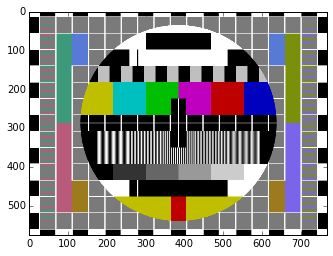

In [4]:
plt.imshow(src)

#### Convert RGB test image to YCrCb

In [5]:
dest = RGB2YCrCb(ctx, src)
Y = cv2.merge((dest[:,:,0],dest[:,:,0],dest[:,:,0]))
Cr = cv2.merge((dest[:,:,1],dest[:,:,1],dest[:,:,1]))
Cb = cv2.merge((dest[:,:,2],dest[:,:,2],dest[:,:,2]))

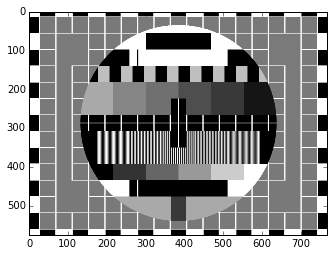

In [6]:
plt.imshow(Y)

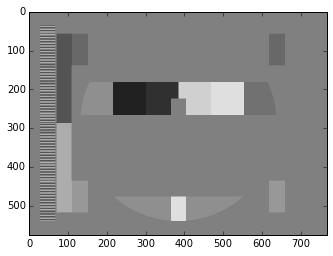

In [7]:
plt.imshow(Cr)

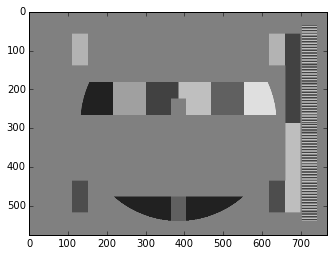

In [8]:
plt.imshow(Cb)

#### Convert YCrCb test image back to RGB

In [9]:
dest2 = YCrCb2RGB(ctx, dest)

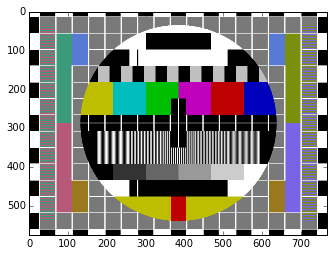

In [10]:
plt.imshow(dest2)

## Visual Angle Tests

#### Constants

In [11]:
sx = 1680 # horizontal screen resolution (px)
sy = 1050 # vertical screen resolution (px)
sw = 473.76 # physical screen width (mm)
sh = 296.1 # physical screen height (mm)

#### Distance of observer (in 3D space) from point on screen

In [12]:
x = [0.0,0.0,1680.0/2.0,1680.0/2.0]
y = [0.0,1050.0/2.0,0.0,1050/2.0]
ez = [700.0]*4
ex = [0.0]*4
ey = [0.0]*4
distance_2_point(ctx, x, y, sx, sy, sw, sh, ez, ex, ey)

array([ 753.67828369,  738.99395752,  715.48498535,  700.        ], dtype=float32)

In [13]:
x = [1680/2]
y = [1050/2]
ez = [700.0]
ex = [0.0]
ey = [0.0]
distance_2_point(ctx, x, y, sx, sy, sw, sh, ez, ex, ey)

array([ 700.], dtype=float32)

#### Distance between two points in degrees of visual angle relative to observer (in 3D space)

In [14]:
x1 = [0]
y1 = [1050/2]
x2 = [1680]
y2 = [1050/2]
ez = [700.0]
ex = [0.0]
ey = [0.0]
subtended_angle(ctx, x1, y1, x2, y2, sx, sy, sw, sh, ez, ex, ey)

array([ 37.39163971], dtype=float32)

In [15]:
N = 1680 * 1050
x1 = np.tile(np.arange(1680),1050)
y1 = np.repeat(np.arange(1050), 1680)
x2 = [1680/2]*N
y2 = [1050/2]*N
ez = [700.0]*N
ex = [0.0]*N
ey = [0.0]*N
subtended_angle(ctx, x1, y1, x2, y2, sx, sy, sw, sh, ez, ex, ey)

array([ 21.75483322,  21.73795509,  21.72109413, ...,  21.69361496,
        21.71051407,  21.72738647], dtype=float32)

## Filter Tests

##### Load test data

In [16]:
df=pd.read_csv(pkg_resources.resource_filename("data","smi.csv"))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3437 entries, 0 to 3436
Data columns (total 16 columns):
smi_time    3437 non-null int64
smi_type    3437 non-null object
smi_sxl     3437 non-null int64
smi_sxr     3437 non-null int64
smi_syl     3437 non-null int64
smi_syr     3437 non-null int64
smi_dxl     3437 non-null int64
smi_dxr     3437 non-null int64
smi_dyl     3437 non-null int64
smi_dyr     3437 non-null int64
smi_exl     3437 non-null float64
smi_exr     3437 non-null float64
smi_eyl     3437 non-null float64
smi_eyr     3437 non-null float64
smi_ezl     3437 non-null float64
smi_ezr     3437 non-null float64
dtypes: float64(6), int64(9), object(1)
memory usage: 456.5+ KB


#### Savitzky–Golay filter

##### Convolve smoothing filter with horizontal gaze coordinates

In [38]:
smooth = savgol_coeffs(11, 2, 0, 1.0/500.0) # window length 2, order 2, derivitive 0
smooth

array([-0.08391608,  0.02097902,  0.1025641 ,  0.16083916,  0.1958042 ,
        0.20745921,  0.1958042 ,  0.16083916,  0.1025641 ,  0.02097902,
       -0.08391608])

In [46]:
x = np.array(df["smi_sxl"], dtype=np.float32) # horizontal gaze
x_np = convolve1d_np(x, smooth) # numpy reference
x_cl = convolve1d(ctx, x, smooth) # gazetools opencl implementation

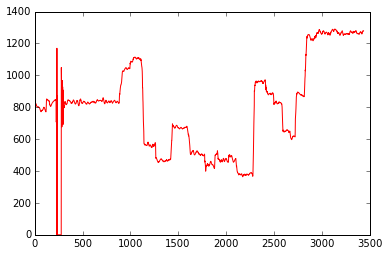

In [48]:
t = np.arange(x.shape[0])
plt.plot(t,x,'r-')

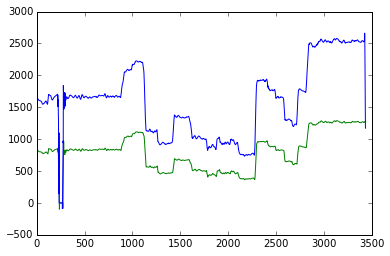

In [49]:
plt.plot(t,x_np,'g-',t,x_cl,'b-')

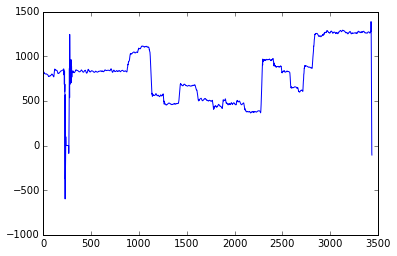

In [51]:
x_diff = x_cl - x_np
plt.plot(t,x_diff)

##### Convolve 1st derivitive filter with horizontal gaze coordinates

In [52]:
velocity = savgol_coeffs(11, 2, 1, 1.0/500.0) # window length 2, order 2, derivitive 0
velocity

array([  2.27272727e+01,   1.81818182e+01,   1.36363636e+01,
         9.09090909e+00,   4.54545455e+00,  -6.83897383e-14,
        -4.54545455e+00,  -9.09090909e+00,  -1.36363636e+01,
        -1.81818182e+01,  -2.27272727e+01])

In [53]:
v_np = convolve1d_np(x, velocity) # numpy reference
v_cl = convolve1d(ctx, x, velocity) # gazetools opencl implementation

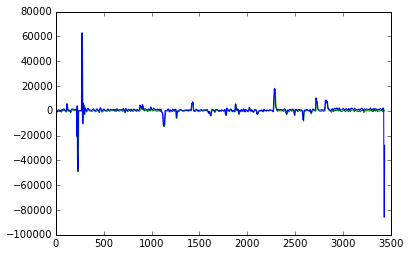

In [54]:
plt.plot(t,v_np,'g-',t,v_cl,'b-')